In [1]:
import pandas as pd
data_30_sentences = pd.read_csv(r'C:\Users\erich\Desktop\DS_project\data\data_30_sentences.csv')

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

lemmatizer = WordNetLemmatizer()

def clean_data(df):
    df = df[df['HTML_Content'].isin(['Explicit', 'General Audiences', 'Mature', 'Not Rated', 'Teen And Up Audiences'])]

    df = df.dropna(subset=['TXT_Content'])

    def clean_text(text):

        if not isinstance(text, str):
            text = str(text)

        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower()
        tokenized_text = word_tokenize(text)
        cleaned_text = [lemmatizer.lemmatize(word) for word in tokenized_text if word not in set(stopwords.words('english'))]

        return ' '.join(cleaned_text)

    df['TXT_Content'] = df['TXT_Content'].apply(clean_text)

    return df

data_30_sentences = clean_data(data_30_sentences)

print(data_30_sentences)

C:\Users\erich\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


               HTML_Content                                        TXT_Content
0     Teen And Up Audiences  huckleberry finn stood front old wooden door m...
1     Teen And Up Audiences  right huck trying figure every sort way could ...
2         General Audiences  three buried mother christmas eve thing huck c...
3     Teen And Up Audiences  air hot brow wet mind exhausted st petersburg ...
4         General Audiences  episode genre al chaos chaos space time vortex...
...                     ...                                                ...
5993  Teen And Up Audiences  seen news pat asked robin chance hang coat mor...
5994  Teen And Up Audiences  free next friday night murphy smiled phone rob...
5995                 Mature  turned walked away wan na say come baby give w...
5996      General Audiences  perfect word tended apply liberally one often ...
5997                 Mature  heaven fact unlike earth pro con pro include t...

[5998 rows x 2 columns]


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Flatten, Attention
from keras.models import Sequential
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import time


# Pre-processing
max_length = 300
embedding_dim = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_30_sentences['TXT_Content'])
sequences = tokenizer.texts_to_sequences(data_30_sentences['TXT_Content'])
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=max_length)

labels = to_categorical(np.asarray(LabelEncoder().fit_transform(data_30_sentences['HTML_Content'])))
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Word Embedding
glove_input_file = 'C:\\Users\\erich\\Desktop\\DS_project\\code\\glove.6B\\glove.6B.100d.txt'
word2vec_output_file = 'C:\\Users\\erich\\Desktop\\DS_project\\code\\glove.6B\\glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

word2vec = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]


C:\Users\erich\AppData\Local\Temp\ipykernel_27572\475069023.py:34: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [4]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], 
                    input_length=max_length, trainable=True))
model.add(LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels[0]), activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history_3 = model.fit(X_train, y_train, 
                    batch_size=128, epochs=3, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

model.reset_states()

history_10 = model.fit(X_train, y_train, 
                    batch_size=128, epochs=10, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

Epoch 1/3
30/30 [==============================] - 738s 25s/step - loss: 1.5529 - accuracy: 0.3077 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5363 - val_accuracy: 0.3406 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
30/30 [==============================] - 723s 24s/step - loss: 1.5358 - accuracy: 0.3239 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5310 - val_accuracy: 0.3406 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
30/30 [==============================] - 854s 29s/step - loss: 1.5256 - accuracy: 0.3260 - precision: 0.3333 - recall: 2.6055e-04 - val_loss: 1.5423 - val_accuracy: 0.3417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 1/10
30/30 [==============================] - 994s 33s/step - loss: 1.5145 - accuracy: 0.3395 - precision: 0.3654 - recall: 0.0050 - val_loss: 1.5394 - val_accuracy: 0.3240 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
30/30 [==============================] - 104

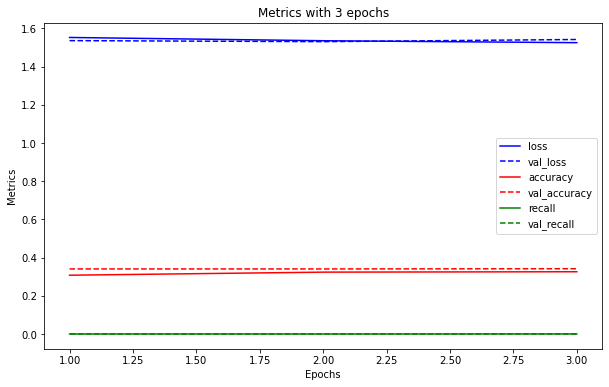

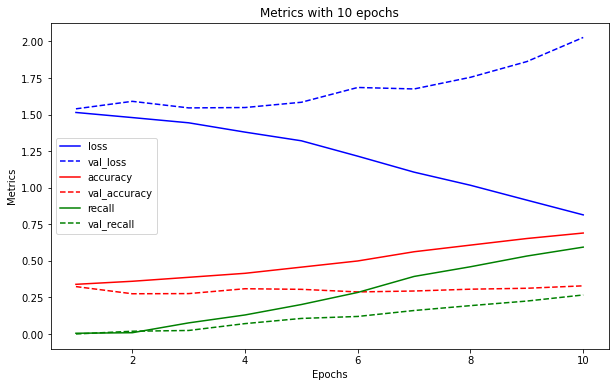

In [6]:
import matplotlib.pyplot as plt
import os

def plot_metrics(history, title, save_dir):
    metrics = ['loss', 'accuracy', 'recall']
    colors = ['blue', 'red', 'green']
    
    plt.figure(figsize=(10, 6))

    for i, metric in enumerate(metrics):
        metric_data = history.history[metric]
        val_metric_data = history.history['val_'+metric]

        epochs = range(1, len(metric_data) + 1)

        plt.plot(epochs, metric_data, color=colors[i], label=metric)
        plt.plot(epochs, val_metric_data, color=colors[i], linestyle="--", label='val_'+metric)
        
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.savefig(os.path.join(save_dir, title.replace(' ', '_')+'.png'))

    plt.show()

save_dir = 'C:\\Users\\erich\\Desktop\\DS_project\\data\\pic'
os.makedirs(save_dir, exist_ok=True)

plot_metrics(history_3, 'Metrics with 3 epochs', save_dir)
plot_metrics(history_10, 'Metrics with 10 epochs', save_dir)